# Building ML Models for SRF Cavity Classification
Chris Tennant <br>
_December 17, 2019_
***

Build up a `Random Forest` model, do hyperparameter tuning with `GridSearchCV` and apply to *ALL* the features (for each of the 4 signals/cavity) to see what kind of accuracy score is achieved (i.e. what do we lose by using only a subset of features?)

Import `pandas`, `matplotlib`, `numpy` and `os` libraries.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

dir = Path('C:/Users/tennant/Desktop/rfw_tsf_extractor-Spring-2018/extracted')

Read in .csv files with features computed by `tsfresh`.

In [26]:
y_master = pd.read_csv(dir/'y_cavity_master.csv')

In [27]:
X_master = pd.read_csv(dir/'X_cavity_master.csv')

In [28]:
y_master = y_master.drop(columns=['zone', 'time'])

In [29]:
X_master = X_master.drop(columns=['zone', 'time'])

In [30]:
print("Number of training examples: {}".format(X_master.shape[0]))
print("Number of features: {}".format(X_master.shape[1]))
print("Number of categories: {}".format(y_master['label'].nunique()))

Number of training examples: 348
Number of features: 24128
Number of categories: 9


To reduce computational load, based on subject matter expert input, we only keep the (GMES, GASK, CRFP, DETA2) signals for each of the 8 cavities.

In [31]:
# number of features computed/signal
int(X_master.shape[1]/4/8)

754

Histogram showing how the distribution of the types of faults in the data set.

In [32]:
y_master['label'].value_counts()

1    72
0    59
6    48
7    41
3    40
4    33
8    31
2    19
5     5
Name: label, dtype: int64

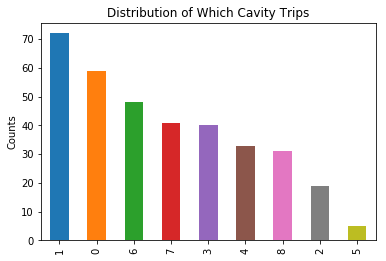

In [33]:
#y_master.T.head(55)
y_master['label'].value_counts().plot(kind='bar');
plt.title("Distribution of Which Cavity Trips");
plt.ylabel("Counts");
#plt.savefig("faults_bar.png", bbox_inches = "tight", dpi=200)

Split the data into training and test sets using `train_test_split` from `sklearn`. Keep 30% of the data for testing. Note that we use `stratify` to ensure that the train and test sets have approximately the same percentage of samples of each target class as the complete set (important when dealing with small data sets like this one).

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_master, y_master, test_size = 0.3, random_state=123, stratify=y_master)

In [35]:
print("The number of training examples is: {}".format(X_train.shape[0]))
print("The number of test examples is: {}".format(X_test.shape[0]))

The number of training examples is: 243
The number of test examples is: 105


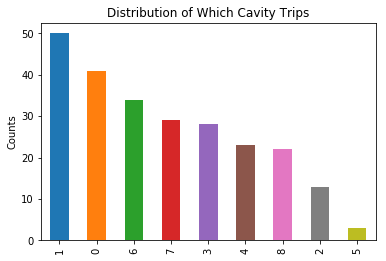

In [36]:
y_train['label'].value_counts().plot(kind='bar');
plt.title("Distribution of Which Cavity Trips");
plt.ylabel("Counts");

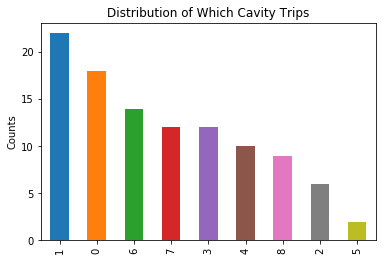

In [37]:
y_test['label'].value_counts().plot(kind='bar');
plt.title("Distribution of Which Cavity Trips");
plt.ylabel("Counts");

Need to standardize features by removing the mean and scaling to unit variance. Note to avoid _data leak_ we standardize the training data and then use the same step (including the same values for mean and standard deviation) on the test set.
<br><br>
_(Note, it may be wise to standardize the initial time-series signals before computing features. However, it requires having all the data together in a single `DataFrame`. Due to computational issues with `tsfresh`, this is not possible and need to compute small batches of data at a time)._

In [38]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(sc.transform(X_test), columns=X_test.columns, index=X_test.index)

Save (mean, variance) values as `numpy` arrays for use with saved model when deployed.

In [39]:
X_train_mean = sc.fit(X_train).mean_
X_train_var = sc.fit(X_train).scale_

np.save('RF_CAVITY_data_mean', X_train_mean, allow_pickle=False)
np.save('RF_CAVITY_data_var', X_train_var, allow_pickle=False)

No need to convert labels (`y_train` and `y_test`) since they are `int64` and not categorical.

In [40]:
from tsfresh import select_features
from tsfresh import feature_selection
from tsfresh.utilities.dataframe_functions import impute

Use `impute` from `tsfresh` to replace all `NaNs` and `infs` from the `DataFrame` with average/extreme values from the same columns.

In [41]:
X_train_scaled = impute(X_train_scaled)
X_test_scaled = impute(X_test_scaled)

Import libraries containing performance metrics and models.

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot

Use the `RandomForest` for its performance and also robustness against overfitting (and general good performance for this problem).

In [43]:
from sklearn.model_selection import GridSearchCV
parameter_candidates = {'n_estimators': np.arange(25,250,25), 'min_samples_split': np.arange(2,18,2), 'max_depth': np.arange(2,18,2)}

Need to reduce `cv` to 3 because of limited data set.

In [44]:
# create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameter_candidates, verbose=1, cv=3)

# train the classifier 
%time clf.fit(X_train_scaled, np.ravel(y_train)) 

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1728 out of 1728 | elapsed: 19.6min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 19min 38s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([ 25,  50,  75, 100, 125, 150, 175, 200, 225]), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16]), 'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [45]:
# view the accuracy score
print('Best accuracy score for training data:', clf.best_score_) 

# view the best parameters for the model found using grid search
print('Best min_samples_split:', clf.best_estimator_.min_samples_split)
print('Best max_depth:', clf.best_estimator_.max_depth)
print('Best n_estimators:', clf.best_estimator_.n_estimators)

Best accuracy score for training data: 0.9218106995884774
Best min_samples_split: 4
Best max_depth: 10
Best n_estimators: 175


In [46]:
RF_model = RandomForestClassifier(n_estimators=175, max_depth=10, min_samples_split=4, max_features=None, random_state=11)
RF_model.fit(X_train_scaled, np.ravel(y_train))
print(RF_model.score(X_test_scaled, np.ravel(y_test)))

0.9619047619047619


Use _k_-folds cross-validation with `cv=3` to check for overfitting with the `RandomForest`.

In [47]:
scores = cross_val_score(RF_model, X_train_scaled, np.ravel(y_train), cv=3)
print("The mean accuracy score is: ({:.2f} +/- {:.2f})%".format(100*scores.mean(), 100*scores.std()))

The mean accuracy score is: (91.14 +/- 4.76)%


In [50]:
# save model using joblib
from sklearn.externals import joblib
from sklearn.externals import joblib

filename_joblib = 'RF_CAVITY_12172019.sav'
joblib.dump(RF_model, filename_joblib)

# save model using pickle
from pickle import dump
from pickle import load

filename_pickle = 'RF_FAULT.pkl'
#dump(RF_model, open(filename_pickle, 'wb'))

Generate a `classification_report` using the `RandomForestClassifier`.

In [49]:
y_pred = RF_model.fit(X_train_scaled, np.ravel(y_train)).predict(X_test_scaled)
print(classification_report(np.ravel(y_test), y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        22
           2       0.75      1.00      0.86         6
           3       1.00      1.00      1.00        12
           4       1.00      0.90      0.95        10
           5       0.00      0.00      0.00         2
           6       0.88      1.00      0.93        14
           7       1.00      0.92      0.96        12
           8       1.00      1.00      1.00         9

   micro avg       0.96      0.96      0.96       105
   macro avg       0.85      0.87      0.85       105
weighted avg       0.95      0.96      0.95       105

